# Imports and Params

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

from src.filters import design_bandpass_iir, design_lowpass_iir, plot_filter_response, export_sos_to_cmsis_header
from scipy.signal import sosfilt, sosfilt_zi
from src.utils import plot_debug_audio_and_peaks, plot_audio_windows, plot_STE_windows, plot_fft_overlay, plot_rms_vs_event, plot_rms_distribution, read_wav_blocks
from src.peak_detector_rt import PeakDetectorNPoint
from src.peak_processor import PeakProcessor 
from src.slab_buffer_manager import SlabBuffer 
from src.peak_validator import PeakValidator 
from src.window_analysis import compute_energy_blocks, hard_limit, find_peaks_window, remove_close_peaks, label_S1_S2_by_fraction, label_s1_s2_audio, make_window_event, populate_window_features

# Slab Buffer Parameters
NUM_BLOCKS = 20
BLOCK_SIZE = 1600

# DSP Parameters
@dataclass
class DSPConfig:
    
    fs: int = 16000

    # Filter Parameters
    bp_lf_cut: int = 30     
    bp_hf_cut: int = 150   
    bp_order: int = 4

    lp_cut: int = 13         
    lp_order: int = 2

    # Real Time Peak Detector Config
    rt_peak_a: float = 0.0001
    rt_peak_thresh: float = 2.0
    rt_peak_min_d: int = 2000

    # Real Time Peak Detector Validator Config
    pv_margin: float = 0.05
    pv_close_r: float = 0.45
    pv_far_r: float = 0.55
 
    # Peak Processor Sample Offset Config
    pp_pre_sample_r: float = 0.25
    pp_min_pre_samples: float = 200
    pp_max_pre_samples: float = 2000

    # Window Processing:
    
    # Hard limiter config
    audio_hl_thresh:float = 1.0 / 3.0
    ste_hl_thresh: float = 0.4

    # STE block size
    ste_block_size: int = 160 # 10ms at 16Khz

    # Window peak detection
    w_peak_thresh: float = 0.7
    w_peak_min_disatnce: int = 1

    # Cluster removal
    c_rmvl_r: float = 0.2

    # S1, S2 classification reject_s1_ratio = 0.3, ratio=0.29, tolerance=0.15)
    cls_reject_s1_r: float = 0.3
    cls_r: float = 0.29
    cls_tol: float = 0.15

    #Analysis window size
    anl_w_size: int = 640


cfg = DSPConfig()





# Filter Design

First row: [ 2.90017034e-07  5.80034067e-07  2.90017034e-07  1.00000000e+00
 -1.93694476e+00  9.38726931e-01]
[[ 2.90017034e-07  5.80034067e-07  2.90017034e-07  1.00000000e+00
  -1.93694476e+00  9.38726931e-01]
 [ 1.00000000e+00  2.00000000e+00  1.00000000e+00  1.00000000e+00
  -1.96746427e+00  9.70689280e-01]
 [ 1.00000000e+00 -2.00000000e+00  1.00000000e+00  1.00000000e+00
  -1.97615793e+00  9.76416797e-01]
 [ 1.00000000e+00 -2.00000000e+00  1.00000000e+00  1.00000000e+00
  -1.99356446e+00  9.93711098e-01]]
CMSIS coeffs written to: output/bandpass_coeffs.h with array name: bandpass_coeffs (NUM_STAGES_BP=4)
CMSIS coeffs written to: output/lowpass_coeffs.h with array name: lowpass_coeffs (NUM_STAGES_LP=1)


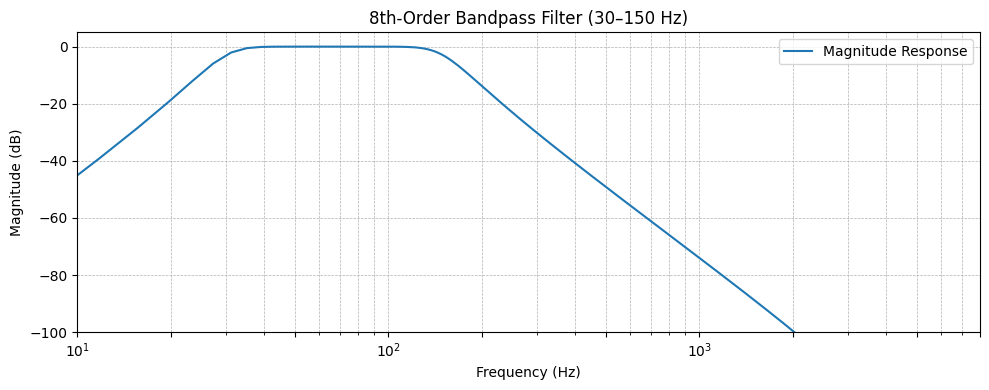

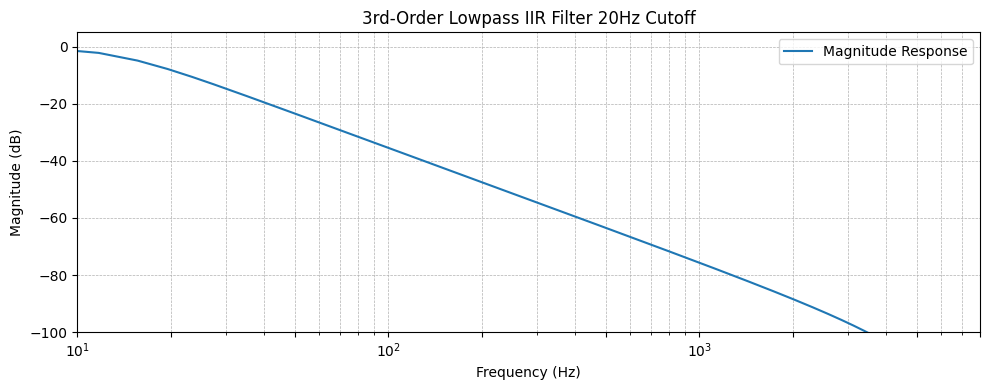

In [2]:
sos_bandpass = design_bandpass_iir(cfg.fs, cfg.bp_lf_cut, cfg.bp_hf_cut, cfg.bp_order)
sos_lowpass = design_lowpass_iir(cfg.fs, cfg.lp_cut, cfg.lp_order)

print("First row:", sos_bandpass[0])
print(sos_bandpass)


plot_filter_response(sos_bandpass, cfg.fs, title="8th-Order Bandpass Filter (30–150 Hz)")
plot_filter_response(sos_lowpass, cfg.fs, title="3rd-Order Lowpass IIR Filter 20Hz Cutoff")
export_sos_to_cmsis_header(sos_bandpass, "output/bandpass_coeffs.h", "bandpass_coeffs", "NUM_STAGES_BP")
export_sos_to_cmsis_header(sos_lowpass, "output/lowpass_coeffs.h", "lowpass_coeffs", "NUM_STAGES_LP")

# Signal Processing

PRE: 2000
attempting to extract window
attempting to get window
PRE: 2000
attempting to extract window
attempting to get window
rms: 0.21988345682621002
rms: 0.24330772459506989
PRE: 1401
attempting to extract window
attempting to get window
rms: 0.18957431614398956
rms: 0.3670748174190521
PRE: 1651
attempting to extract window
attempting to get window
PRE: 2000
attempting to extract window
attempting to get window
rms: 0.3582656681537628
rms: 0.1915515661239624
PRE: 2000
attempting to extract window
attempting to get window
rms: 0.37783607840538025
rms: 0.22875520586967468
PRE: 2000
attempting to extract window
attempting to get window
rms: 0.24547405540943146
rms: 0.2741442918777466
PRE: 2000
attempting to extract window
attempting to get window
rms: 0.19775602221488953
rms: 0.2729738652706146
PRE: 2000
attempting to extract window
attempting to get window
rms: 0.285220205783844
rms: 0.25192105770111084
PRE: 2000
attempting to extract window
attempting to get window
rms: 0.5290206074

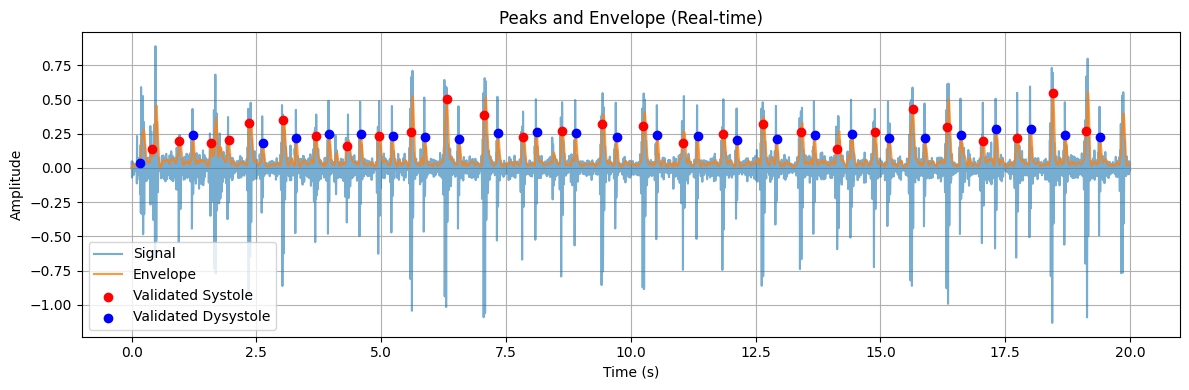

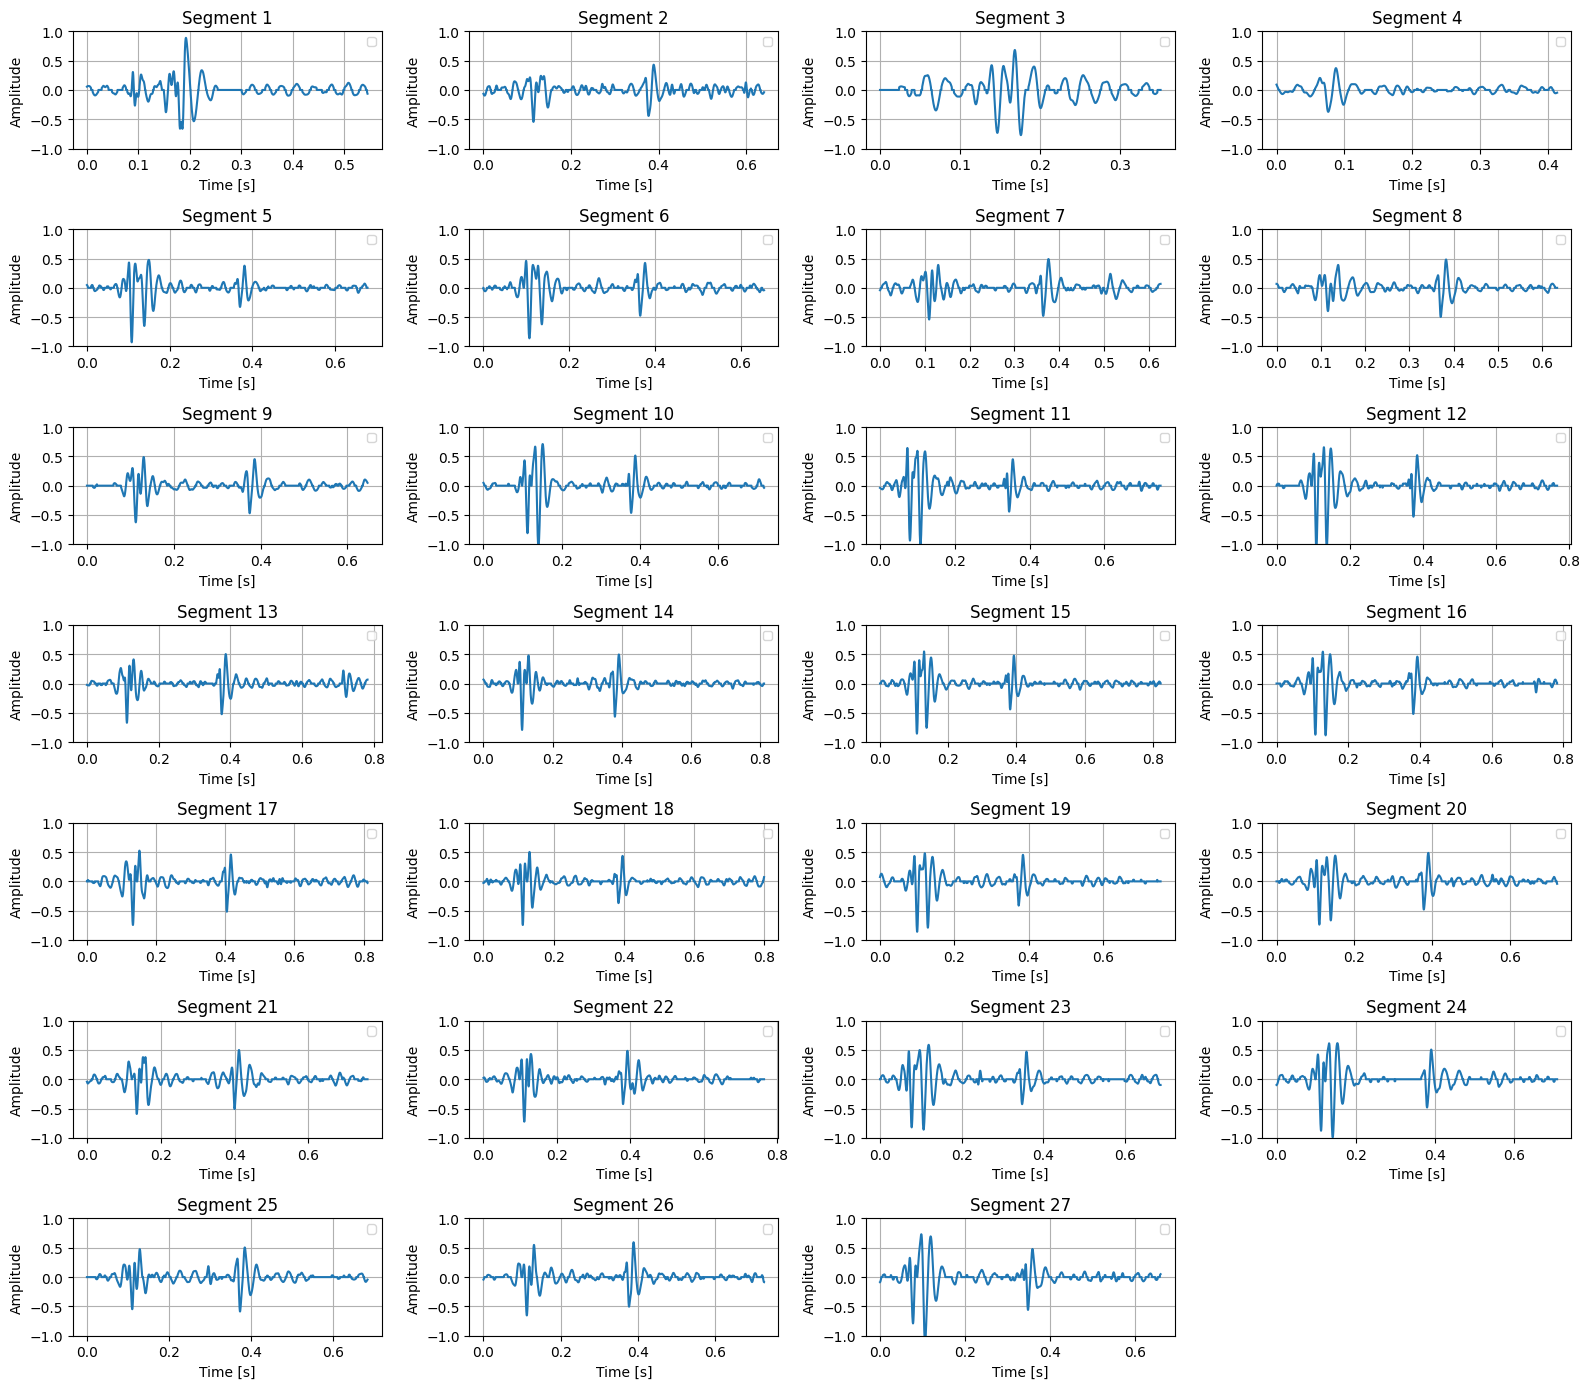

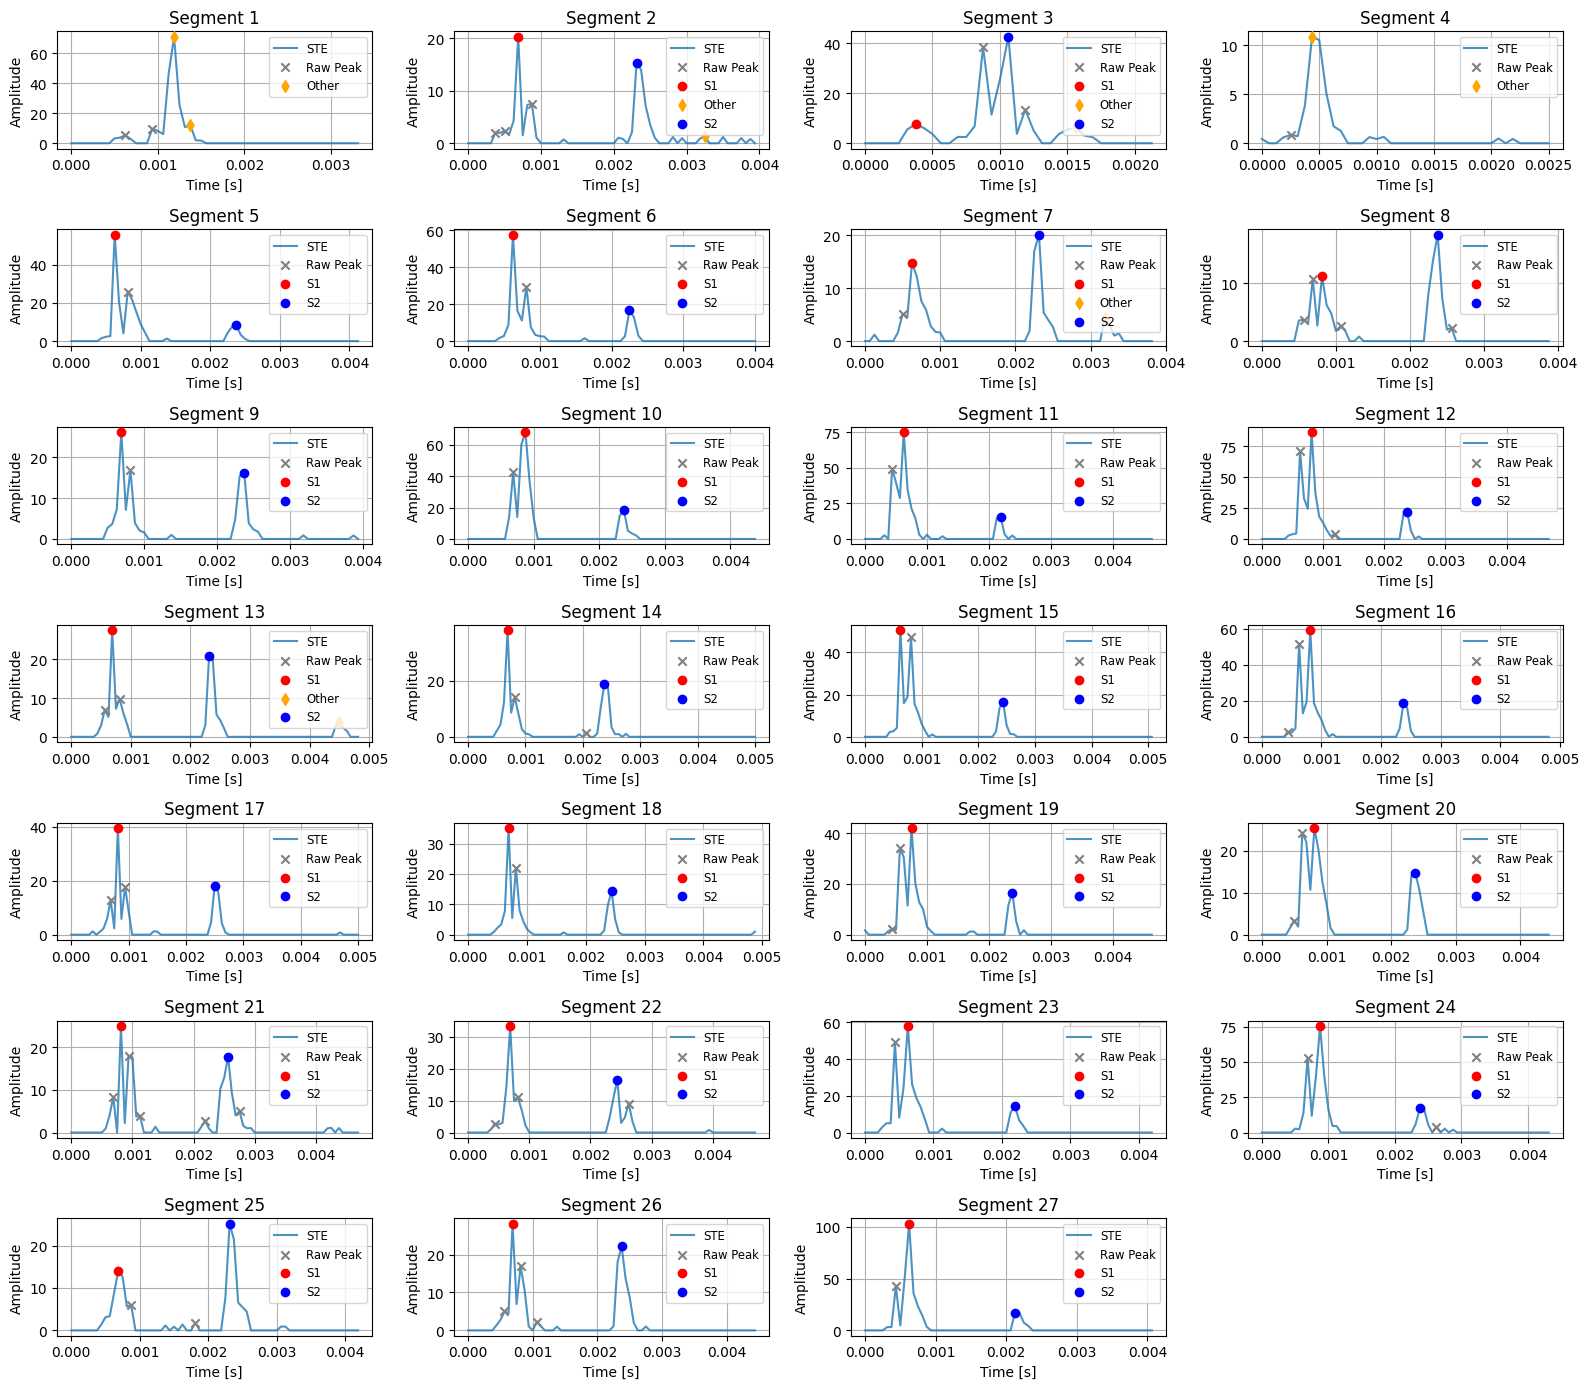

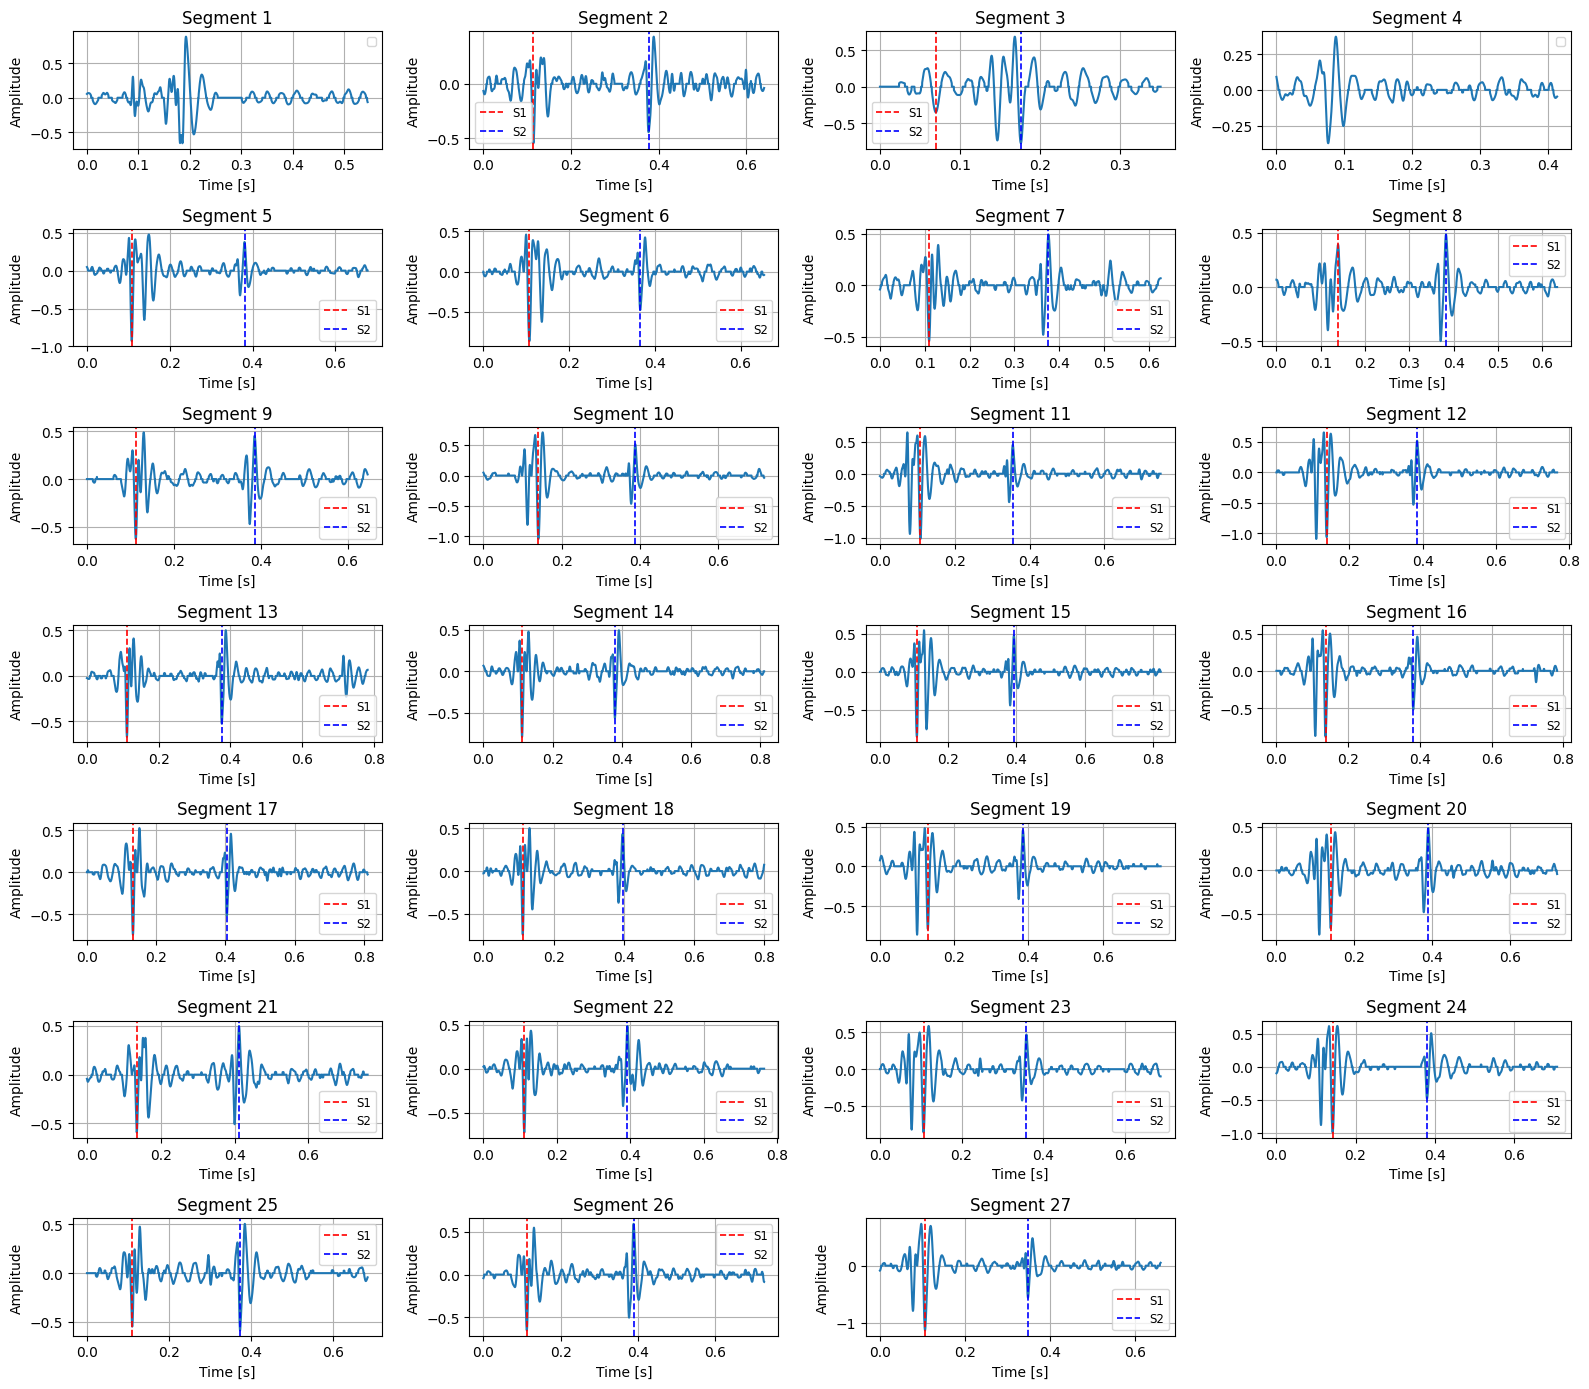

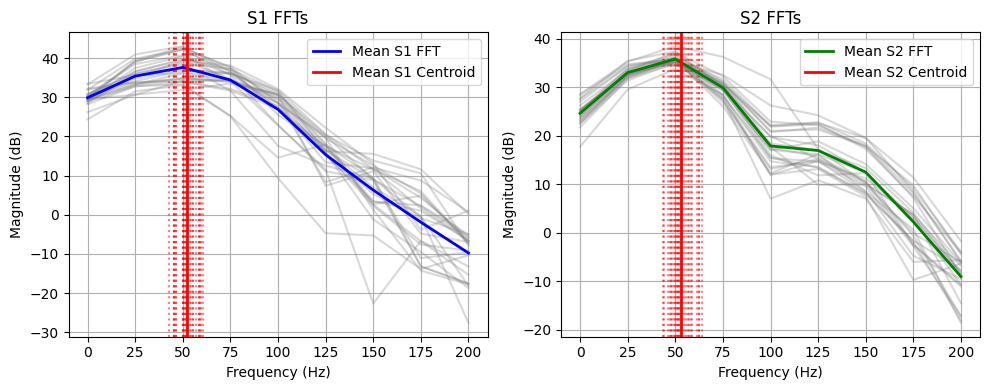

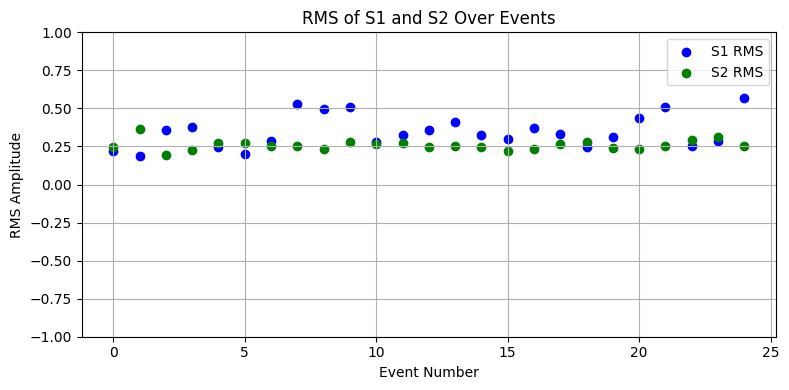

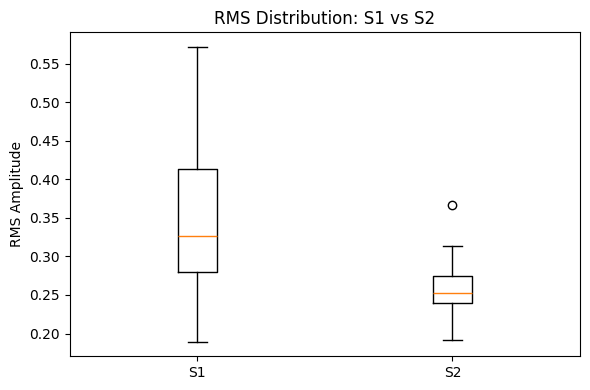

In [3]:
# Buffers & State
slab_buffer = SlabBuffer(NUM_BLOCKS, BLOCK_SIZE)  
peak_queue = [] #
debug_global_peaks = [] #
debug_audio_blocks = [] #
debug_envelope = [] #
debug_energies = []
debug_window_queue = []
debug_ste_window_queue = []
debug_ste_peaks_queue = []
debug_audio_peaks = []
debug_window_events = []

# Filters
sos_bandpass = design_bandpass_iir(cfg.fs, cfg.bp_lf_cut, cfg.bp_hf_cut, cfg.bp_order)
bp_zi = sosfilt_zi(sos_bandpass) * 0
sos_lowpass = design_lowpass_iir(cfg.fs, cfg.lp_cut, cfg.lp_order)
lp_zi = sosfilt_zi(sos_lowpass) * 0

cardiac_cycle_peak_detector = PeakDetectorNPoint(slab_buffer.block_size, slab_buffer.num_blocks, cfg.rt_peak_a, cfg.rt_peak_thresh, cfg.rt_peak_min_d)

def process_window(window, window_start_index):

    # 0. Get time_stamp of window
    window_time_ms = (window_start_index / cfg.fs) * 1000

    # 1. Hard limit audio
    limited_window = hard_limit(window, cfg.audio_hl_thresh)
    debug_window_queue.append(limited_window)

    # 2. Compute STE
    ste = compute_energy_blocks(limited_window, fs=cfg.fs, samples_per_window=cfg.ste_block_size)

    # 3. Hard Limit STE energy
    limited_ste = hard_limit(ste, cfg.ste_hl_thresh)
    debug_ste_window_queue.append(limited_ste)

    # 4. Find STE peaks
    ste_mean = np.mean(ste)
    segment_peaks = find_peaks_window(limited_ste, ste_mean, cfg.w_peak_thresh, cfg.w_peak_thresh)

    # 5. De-cluster peaks
    cardiac_period_STE = len(ste)
    de_clustered_peaks = remove_close_peaks(segment_peaks, cfg.c_rmvl_r, cardiac_period_STE)

    # 6. Label STE peaks as S1 and S2
    tagged_peaks = label_S1_S2_by_fraction(de_clustered_peaks, cardiac_period_STE, cfg.cls_reject_s1_r, cfg.cls_r, cfg.cls_tol)
    debug_ste_peaks_queue.append(tagged_peaks)

    # 7. Retrieve locations of peaks in audio
    audio_peaks = label_s1_s2_audio(tagged_peaks, limited_ste, window, cfg.ste_block_size)
    debug_audio_peaks.append(audio_peaks)

    # 8. Create sub window and compute FFT find centroid of both S1 and S2
    cardiac_window_event = make_window_event(window, limited_ste, window_time_ms)
    cardiac_window_event = populate_window_features(cardiac_window_event, audio_peaks, window, cfg.fs, cfg.anl_w_size)
    debug_window_events.append(cardiac_window_event)


peak_processor = PeakProcessor(process_window)

def pv_send_fn(msg):
    peak_queue.append(msg)
    debug_global_peaks.append(msg.copy())

peak_validator = PeakValidator(pv_send_fn, cfg.pv_margin, cfg.pv_close_r, cfg.pv_far_r)

def process_block(block, fs):
    global bp_zi, lp_zi

    # 1. Filter and write audio to slab buffer
    filtered_signal, bp_zi = sosfilt(sos_bandpass, block, zi=bp_zi)
    slab_buffer.write_block(filtered_signal)
    slab_buffer.advance_write_index()
    debug_audio_blocks.append(filtered_signal.copy())

    # 2. Envelope generation
    abs_block = np.abs(filtered_signal)
    envelope, lp_zi = sosfilt(sos_lowpass, abs_block, zi=lp_zi)
    debug_envelope.append(envelope.copy())

    # 3. Peak detection and validation in preparation for cardiac windowing
    block_absolute_start = slab_buffer.absolute_sample_index - slab_buffer.block_size
    for i, sample in enumerate(envelope):
        abs_idx_of_sample = block_absolute_start + i
        peak_validator.update()
        peak_message = cardiac_cycle_peak_detector.update(sample, i, abs_idx_of_sample)

        if (peak_message):
            # print(f"index: {peak_message['sample_index']}, "
            # f"value: {peak_message['value']:.4f}")
            peak_validator.notify_peak(peak_message)

    # 4. Create cardiac cycle windows based on Systolic periodså
    peak_processor.process_peak_events(peak_queue, slab_buffer, cfg.pp_pre_sample_r, cfg.pp_min_pre_samples, cfg.pp_max_pre_samples)

#read_wav_blocks("./data/circore/33151_MV.WAV", block_size_samples=1600, process_block_fn=process_block)
read_wav_blocks("./data/tri_00000001.WAV", block_size_samples=1600, process_block_fn=process_block)
plot_debug_audio_and_peaks(debug_audio_blocks, debug_global_peaks, debug_envelope, debug_energies, file_loc="./output/discarded.png")
plot_audio_windows(debug_window_queue, y_lim=1)
plot_STE_windows(debug_ste_window_queue, debug_ste_peaks_queue, y_lim=None)
plot_audio_windows(debug_window_queue, debug_audio_peaks, y_lim=None)
plot_fft_overlay(debug_window_events)
plot_rms_vs_event(debug_window_events, y_lim = 1)
plot_rms_distribution(debug_window_events)
